In [1]:
from google.colab import drive
drive.mount("/content/drive") 


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Import necessary libraries 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.model_selection import train_test_split
%reload_ext autoreload
%autoreload 2
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# import fast.ai libraries for nlp

from fastai import *
from fastai.text import *

In [4]:
import fastai.utils.collect_env

fastai.utils.collect_env.show_install()



```text
=== Software === 
python        : 3.6.9
fastai        : 1.0.61
fastprogress  : 0.2.3
torch         : 1.5.0+cu101
nvidia driver : 418.67
torch cuda    : 10.1 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Wed Feb 19 05:26:34 PST 2020
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installed, re-run

In [5]:
from zipfile import  ZipFile
file_name = "/content/drive/My Drive/Tweets.zip"
with ZipFile(file_name , "r") as zip:
  zip.extractall()
  print("finish")

finish


In [0]:
df_airline = pd.read_csv("Tweets.csv")

In [7]:
df_airline.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [10]:
df_final = df_airline[['airline_sentiment' , 'text']]
pd.set_option('display.max_colwidth',0)
df_final.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


In [12]:
df_final.isnull().sum()   #check for missing values in data

airline_sentiment    0
text                 0
dtype: int64

In [13]:


#Data is skewed more towards the negative sentiment
df_final['airline_sentiment'].value_counts()



negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

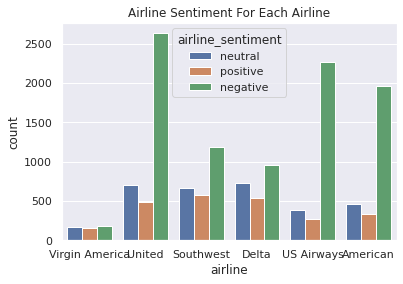

In [17]:
#Visualize the sentiment for each airline
sns.countplot(x="airline", hue='airline_sentiment', data=df_airline)
plt.title("Airline Sentiment For Each Airline");

In [19]:
import re
reg = r"@(VirginAmerica|united|SouthwestAir|Delta|USAirways|AmericanAir)"

def replace_text(text):
  return re.sub(reg , "@airline" , text , flags = re.IGNORECASE)


df_final['text'] = df_final['text'].apply(replace_text)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:


df_final.head(5)



,airline_sentiment,text
0,neutral,@airline What @dhepburn said.
1,positive,@airline plus you've added commercials to the experience... tacky.
2,neutral,@airline I didn't today... Must mean I need to take another trip!
3,negative,"@airline it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@airline and it's a really big bad thing about it


In [0]:
#Split the dataframe randomly into train set and valid set. 
train, dev = train_test_split(df_final, test_size=0.1)


In [33]:
#TextLMDataBunch only accepts two separate dataframes for train and valid
data_lm = TextLMDataBunch.from_df(file_name, train_df = train, valid_df = dev)

In [34]:


data_lm.show_batch()



idx,text
0,"4 ! xxup horrible xxbos @airline thanks , i 'll look forward to the response . xxbos @airline xxmaj but you called me - and hung up . xxbos @airline you advertise the flight and its still on you website and still ca n't be book . spent over 2 hours with united support xxbos @jetblue what is going on with your xxup bdl to xxup dca flights yesterday and"
1,our fleet 's on fleek . http : / / t.co / xxunk ” xxmaj jet xxmaj xxunk in the xxunk . xxbos @airline hi when will your next set of flights be out for next year from xxmaj dublin ? ? ? xxbos @airline has the xxup worst customer service and their flights are always delayed xxbos @jetblue today my family gets to experience # mosaic status w /
2,can get tickets ? xxbos @jetblue xxup thank xxup you ! i am your new big fan :) xxbos @airline xxup luv ! your new xxmaj luv xxmaj television xxmaj commercials . xxmaj traveled on your airline last year return trip from xxup nyc ... # xxunk xxbos @airline can you help xxbos @airline can you assist with current flight status for flt # xxunk out of xxup dfw tomorrow
3,a lot faster than xxunk mph with a strong tailwind . xxbos @airline xxmaj our flight was originally supposed to leave at xxunk & & now we wo n't leave until 5 . xxmaj this is the 2nd time this has happened xxbos xxmaj then you better # xxunk - # xxunk @jetblue 4 our # brandloveaffair https : / / t.co / xxunk # truebluelove # travel # business
4,"phones # horribleservice # neveragain # frustrated # answerthephone xxbos @airline xxup sf crew lack a lot of customer service , xxup lax employees are a lot better . xxmaj wonder why ... xxbos @airline xxmaj am i xxunk or is there a magic code to make your customer service site work ? http : / / t.co / xxunk xxbos @airline @ny_njairports xxmaj do you guys teach poor customer"


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5, model_dir='/tmp/models')
learn.freeze()

In [36]:
#To Find the proper learning rate, use the x value where the slope is steepest in the -y direction.
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


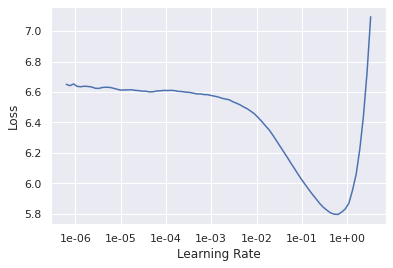

In [37]:
learn.recorder.plot()

In [45]:
lr = 1.0E-02
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,2.757701,3.742491,0.316183,00:28


In [0]:
learn.unfreeze()

In [47]:
learn.fit_one_cycle(4, lr, moms=(0.5,0.6), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,2.434309,3.866758,0.302427,00:28
1,2.688972,3.840204,0.308064,00:28
2,2.372782,3.934592,0.311775,00:28
3,1.810927,4.094215,0.308984,00:28


In [48]:
learn.predict('XYZ', n_words=10)

"XYZ “ @jetblue : Our fleet 's on fleek ."

In [0]:
learn.save_encoder('save')

In [0]:
#classify fine tunning
#Split the dataframe randomly into train set and valid set. 
train_dev, test = train_test_split(df_final, test_size=0.1)
train, dev = train_test_split(train_dev, test_size=0.1)

In [51]:
data_clas = TextClasDataBunch.from_df(file_name , train_df=train, valid_df = dev ,test_df = test, vocab=data_lm.train_ds.vocab, 
                                      text_cols='text', label_cols='airline_sentiment', bs=48)

In [52]:
data_clas.show_batch()

text,target
xxbos @airline xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @airline xxup where xxup is xxup my xxup fucking xxup bag ? ! ? ! xxmaj where the fuck is my fucking bag ? ? ? xxup tell xxup me xxup now xxup or xxup give xxup me a xxup number xxup to xxup call a xxup human . xxup san68059 m,negative
"xxbos @airline 4 segments , 4 / 4 delayed . xxmaj gnv > xxup ctl . xxup ctl > xxup jan . xxup jan > xxup ctl . xxup ctl > xxup gnv . xxmaj my year off from flying with you guys was the way to go .",negative
xxbos @airline - xxup seriously it 's 2015 ? ! ? ! xxup no wifi on a 5hr flight from xxup cle - xxup sfo # xxunk . xxmaj you 're the xxup only airline w / out wifi ... and pls no ' xxunk ' xxup bs .,negative
"xxbos @airline xxmaj waiting for 3494 xxup ewr - xxup ord , delayed 47 mins . xxmaj might miss xxunk xxup ord - xxup ywg at 6 pm xxup xxunk . xxmaj any room on xxunk xxup ord - xxup ywg in case i miss xxunk ?",negative


In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, model_dir='/tmp/models')
learn.load_encoder('save')
learn.freeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


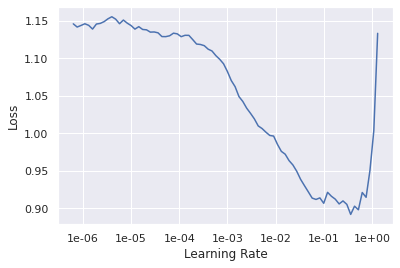

In [55]:
learn.lr_find()
learn.recorder.plot()

In [56]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), wd=0.1)  #ULMFIT method give better performance

epoch,train_loss,valid_loss,accuracy,time
0,0.590388,0.470529,0.817906,00:15


In [57]:
#RESULT MODEL EVALUATION

learn.predict('XYZ')



(Category tensor(1), tensor(1), tensor([0.1891, 0.6222, 0.1888]))

In [58]:


interp = TextClassificationInterpretation.from_learner(learn)
acc = accuracy(interp.preds, interp.y_true)
print('Accuracy: {0:.3f}'.format(acc))



Accuracy: 0.818


Text(0.5, 1.0, 'Classifation Confusion Matrix')

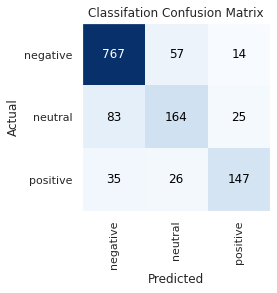

In [59]:
interp.plot_confusion_matrix()
plt.title('Classifation Confusion Matrix')